### Use Case 2: Image Description Generation

#### 1. Set Up the Environment

In [1]:
pip install tensorflow keras numpy pandas nltk

Defaulting to user installation because normal site-packages is not writeable
  Using cached keras-3.6.0-py3-none-any.whl.metadata (5.8 kB)
     ---------------------------------------- 0.0/59.7 kB ? eta -:--:--
     ------ --------------------------------- 10.2/59.7 kB ? eta -:--:--
     ------------- ------------------------ 20.5/59.7 kB 330.3 kB/s eta 0:00:01
     -------------------------------- ----- 51.2/59.7 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 59.7/59.7 kB 454.1 kB/s eta 0:00:00
Using cached keras-3.6.0-py3-none-any.whl (1.2 MB)
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
    --------------------------------------- 0.2/15.6 MB 3.7 MB/s eta 0:00:05
    --------------------------------------- 0.4/15.6 MB 3.7 MB/s eta 0:00:05
   - -------------------------------------- 0.5/15.6 MB 3.6 MB/s eta 0:00:05
   - -------------------------------------- 0.7/15.6 


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 2. Import Libraries

In [2]:
import pandas as pd
import string
import pickle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os

### 3. Load and Read Captions

In [3]:
# Define the path to the captions CSV file
captions_file = 'D:/Jupyter/Image Description/results.csv'

# Load the captions CSV file
captions = pd.read_csv(captions_file, delimiter='|')

# Display the first few rows to inspect
print(captions.head())
print(captions.shape)

       image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  
(158915, 3)


### 4. Data Preprocessing

##### 4.1 Clean Up Column Names

In [4]:
# Remove leading or trailing spaces in column names
captions.columns = captions.columns.str.strip()

##### 4.2. Remove or Fill Missing Values

In [5]:
# Fill missing values in 'comment' column with an empty string
captions['comment'].fillna('', inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15996\1613048732.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  captions['comment'].fillna('', inplace=True)


##### 4.3. Clean the Captions

In [6]:
import re

# Function to clean text
def clean_caption(caption):
    caption = caption.lower()  # Convert to lowercase
    caption = re.sub(r"[^a-zA-Z0-9\s]", "", caption)  # Remove punctuation
    caption = caption.split()  # Tokenize by splitting on whitespace
    caption = [word for word in caption if len(word) > 1]  # Remove short words
    return " ".join(caption)  # Join words back to a cleaned sentence

# Apply the cleaning function to the 'comment' column
captions['cleaned_comment'] = captions['comment'].apply(clean_caption)

# Display the first few rows to verify the cleaning
print(captions[['comment', 'cleaned_comment']].head())


                                             comment  \
0   Two young guys with shaggy hair look at their...   
1   Two young , White males are outside near many...   
2   Two men in green shirts are standing in a yard .   
3       A man in a blue shirt standing in a garden .   
4            Two friends enjoy time spent together .   

                                     cleaned_comment  
0  two young guys with shaggy hair look at their ...  
1  two young white males are outside near many bu...  
2       two men in green shirts are standing in yard  
3               man in blue shirt standing in garden  
4              two friends enjoy time spent together  


##### 4.4. Tokenize the Captions and Save

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions['comment'])

# Convert captions to sequences of integers
captions['caption_seq'] = tokenizer.texts_to_sequences(captions['comment'])

# Check the first few tokenized sequences
print(captions[['comment', 'caption_seq']].head())

                                             comment  \
0   Two young guys with shaggy hair look at their...   
1   Two young , White males are outside near many...   
2   Two men in green shirts are standing in a yard .   
3       A man in a blue shirt standing in a garden .   
4            Two friends enjoy time spent together .   

                                         caption_seq  
0  [11, 20, 325, 9, 2037, 87, 186, 15, 61, 158, 2...  
1           [11, 20, 19, 709, 12, 53, 78, 193, 1426]  
2            [11, 28, 2, 45, 222, 12, 30, 2, 1, 489]  
3                [1, 6, 2, 1, 24, 18, 30, 2, 1, 711]  
4                     [11, 487, 812, 588, 9847, 137]  


In [8]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

##### 4.5 Vocabulary Creation

In [9]:
from collections import Counter
import pickle

# Flatten the list of tokenized captions into a single list of words
all_words = [word for caption in captions['cleaned_comment'] for word in caption.split()]

# Create a Counter to find word frequencies
word_counts = Counter(all_words)

# Limit vocabulary to top N words (e.g., 5000) based on frequency
vocab_size = 5000
vocabulary = [word for word, count in word_counts.most_common(vocab_size)]

# Save vocabulary as a pickle file for future use
with open("vocabulary.pkl", "wb") as f:
    pickle.dump(vocabulary, f)

print(f"Vocabulary size: {len(vocabulary)}")
print(f"First 10 words in vocabulary: {vocabulary[:10]}")


Vocabulary size: 5000
First 10 words in vocabulary: ['in', 'the', 'on', 'and', 'man', 'is', 'of', 'with', 'woman', 'two']


##### 4.6 Sequence Preparation

In [10]:
# Create sequences for each caption
sequences = []
for caption in captions['cleaned_comment']:
    words = caption.split()
    for i in range(1, len(words)):
        # Input sequence: All words up to the i-th word
        in_seq = words[:i]
        # Output word: The i-th word
        out_word = words[i]
        sequences.append((in_seq, out_word))

# Display a sample of the generated sequences
print(f"Total sequences created: {len(sequences)}")
print("Sample sequences:")
for i in range(5):
    print(f"Input: {sequences[i][0]}, Output: {sequences[i][1]}")


Total sequences created: 1514180
Sample sequences:
Input: ['two'], Output: young
Input: ['two', 'young'], Output: guys
Input: ['two', 'young', 'guys'], Output: with
Input: ['two', 'young', 'guys', 'with'], Output: shaggy
Input: ['two', 'young', 'guys', 'with', 'shaggy'], Output: hair


### 5. Exploratory Data Analysis

##### 5.1 Plot the Distribution of Caption Lengths

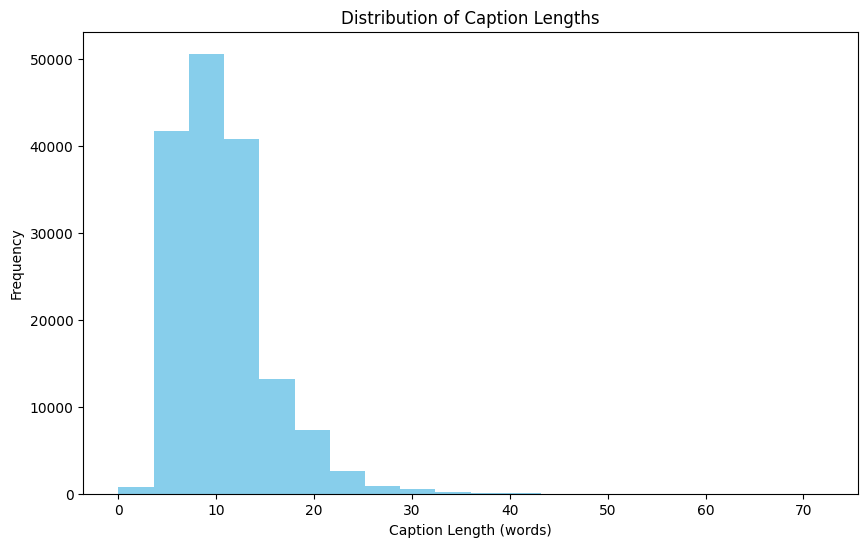

In [11]:
import matplotlib.pyplot as plt

# Calculate caption lengths
captions['caption_length'] = captions['cleaned_comment'].apply(lambda x: len(x.split()))

# Plot the distribution of caption lengths
plt.figure(figsize=(10, 6))
plt.hist(captions['caption_length'], bins=20, color='skyblue')
plt.title('Distribution of Caption Lengths')
plt.xlabel('Caption Length (words)')
plt.ylabel('Frequency')
plt.show()


##### 5.2 Analyze Word Frequency

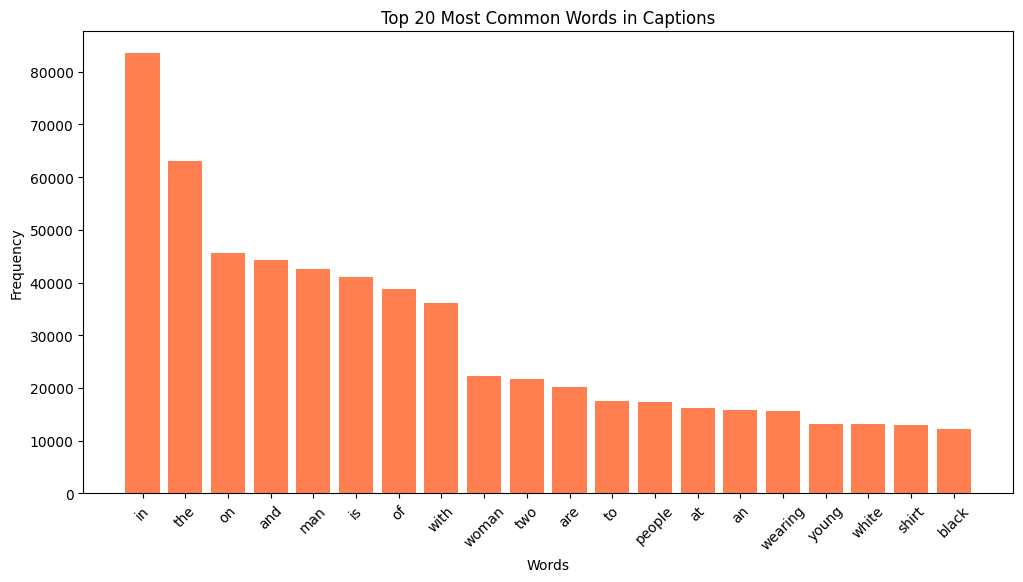

In [12]:
from collections import Counter

# Flatten the list of words from all captions
all_words = [word for caption in captions['cleaned_comment'] for word in caption.split()]

# Count word frequencies
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

# Plot the most common words
words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='coral')
plt.title('Top 20 Most Common Words in Captions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


### 6. Implement Statistical Test of Comparisons

Hypothesis 1: Longer captions contain a higher diversity of vocabulary than shorter captions.

Null Hypothesis (H0): There is no significant difference in vocabulary diversity between longer and shorter captions.

Alternative Hypothesis (H1): Longer captions have significantly higher vocabulary diversity than shorter captions.

In [19]:
from scipy.stats import mannwhitneyu

# Define the threshold for caption length (e.g., median)
length_threshold = captions['caption_length'].median()

# Calculate diversity as the number of unique words per caption
captions['unique_word_count'] = captions['cleaned_comment'].apply(lambda x: len(set(x.split())))

# Define two groups: long and short captions based on length threshold
long_captions = captions[captions['caption_length'] > length_threshold]['unique_word_count']
short_captions = captions[captions['caption_length'] <= length_threshold]['unique_word_count']

# Perform Mann-Whitney U test to compare vocabulary diversity
u_stat, p_value = mannwhitneyu(long_captions, short_captions)

print("Mann-Whitney U Test Results for Vocabulary Diversity:")
print(f"U-statistic = {u_stat:.2f}")
print(f"p-value = {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in vocabulary diversity between long and short captions.")
else:
    print("No significant difference in vocabulary diversity between long and short captions.")


Mann-Whitney U Test Results for Vocabulary Diversity:
U-statistic = 6086059547.00
p-value = 0.0000
There is a significant difference in vocabulary diversity between long and short captions.


### 5. Feature Extraction

##### 5.1 Load VGG-16 for Feature Extraction and Process each Image

In [11]:
# Load the VGG16 model
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)  # Use the last layer before the classification layer

# Directory where images are stored
image_dir = 'D:/Jupyter/Image Description/images/flickr30k_images'

# Function to extract features from an image
def extract_features(image_path):
    # Load the image with the target size of 224x224
    image = load_img(image_path, target_size=(224, 224))
    # Convert the image to an array and preprocess it
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    # Pass the image through the model and extract features
    feature = model.predict(image, verbose=0)
    return feature.flatten()

# Extract features for all images and save them in a dictionary
features = {}
for img_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, img_name)
    features[img_name] = extract_features(image_path)

# Save the features to a file for later use
import pickle
with open('image_features.pkl', 'wb') as f:
    pickle.dump(features, f)

##### 5.2 Load Image features from Pickle

In [18]:
# Load the image features
with open('image_features.pkl', 'rb') as f:
    features = pickle.load(f)